#  Quantiphi Dog Breed Classification Challenge

### Concept of Transfer Learning
Transfer learning refers to the technique of using knowledge of one domain to another domain.i.e. a NN model trained on one dataset can be used for other dataset by fine-tuning the former network.

### When to use it?
This is a function of several factors, but the two most important ones are the size of the new dataset (small or big), and its similarity to the original dataset (e.g. ImageNet-like in terms of the content of images and the classes, or very different). Our Case is:

New dataset is small and somewhat similar to original dataset. Since the data is small, it is not a good idea to fine-tune the ConvNet due to overfitting concerns. Since the data is similar to the original data, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on the CNN codes.

#### This approach is to leverage a network pre-trained on a large dataset. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

We will use the VGG16 architecture, pre-trained on the ImageNet dataset. Because the ImageNet dataset contains several "Dog" classes among its total of 1000 classes, this model will already have learned features that are relevant to our classification problem. 

In fact, it is possible that merely recording the softmax predictions of the model over our data rather than the bottleneck features would be enough to solve our dogs breed classification problem well. 

However, the method present here is more likely to generalize well to a broader range of problems, including problems featuring classes absent from ImageNet.

In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
compare_loss={}
compare_accuracy={}

In [9]:
# check if all pre trained models are present
start = dt.datetime.now()
!ls ./input/keras-pretrained-models/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [11]:
# copy all keras pre trained models to where keras/models exists
!cp ./input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ./input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ./input/keras-pretrained-models/resnet50* ~/.keras/models/

'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
# list the models copied
!ls ~/.keras/models

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [13]:
# function to convert image to array
def read_img(address, size):
    """Read and resize image.
    Returns Image as numpy array, by normalizing the values
    """
    img = image.load_img(address, target_size=size)
    img = image.img_to_array(img)
    return img

# function to convert labels to one hot encoding vector
def OneHotEncoded(y_train):
    y_t=np.zeros((len(y_train),Num_Class), dtype=int)
    for i,x in enumerate(y_train):
        y_t[i][int(x)-1]=1
    return y_t

    

In [14]:
#133 labels
# Preprocess labels and create a csv file to keep track of labels, along with their encoded vector
import os
import csv
from shutil import copy2
INPUT_SIZE = 224
directory_lists=os.listdir("./data/")
labels={}
data={}
with open('./input/dog-breed-identification/labels.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['id','breed','encoded_value'])
    for i in range(0,len(directory_lists)):
        t=directory_lists[i].split(".")
        imag=os.listdir("./data/"+str(directory_lists[i]))
        current_loc="./data/"+str(directory_lists[i])+"/"
        for k in range(0,len(imag)):
            x=[current_loc+str(imag[k])]+[t[1]]+[t[0]]
            writer.writerow(x)
data_dir = './input/dog-breed-identification'
labels = pd.read_csv(join(data_dir, 'labels.csv'))

#### This is our First Method, Here we will Extract VGG16 bottleneck features, by forward passing the processed image data, and then using this forward pass data as input to logistic regression for classification.
We don't need any form of preprocessing on our image data, that has been handled by preprocess_input function of VGG.

In [15]:
# Feature Extraction for our Network
INPUT_SIZE = 224
POOLING = 'avg'
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
y_train= np.zeros((len(labels),), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
    y_train[i]=int(labels['encoded_value'][i])
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

8351it [01:18, 106.80it/s]


Train Images shape: (8351, 224, 224, 3) size: 1,257,059,328


In [16]:
Num_Class=133   # number of classes in dataset
# convert labels to one hot encoding
y_train=OneHotEncoded(y_train)
# split data in to training and validation set
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

In [17]:
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)
train_vgg_bf = vgg_bottleneck.predict(X_train, batch_size=32, verbose=1)
valid_vgg_bf = vgg_bottleneck.predict(X_val, batch_size=32, verbose=1)
print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))

2756/2756 [==============================] - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 27s 10ms/step
VGG train bottleneck features shape: (5595, 512) size: 2,864,640
VGG valid bottleneck features shape: (2756, 512) size: 1,411,072


### we just use last layer as logistic regression, basically one layered neural network(cross entropy). The accuracy we obtained is around 78.73%

In [18]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=147)
logreg.fit(train_vgg_bf, (y_train * range(Num_Class)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)
compare_loss['Vgg16']=log_loss(y_val, valid_probs)
compare_accuracy['Vgg16']=accuracy_score((y_val * range(Num_Class)).sum(axis=1), valid_preds)
print('Validation VGG LogLoss {}'.format(compare_loss['Vgg16']))
print('Validation VGG Accuracy {}'.format(compare_accuracy['Vgg16']))

Validation VGG LogLoss 1.2253131858872046
Validation VGG Accuracy 0.7873730043541364


### Here we will test with Xception bottleneck features, and use these features to train logistic regression.

In [19]:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
y_train= np.zeros((len(labels),), dtype='float32')

for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0)) # preprocessing data for Xception model
    x_train[i] = x
    y_train[i]=int(labels['encoded_value'][i])
    
y_train=OneHotEncoded(y_train)

X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

8351it [01:42, 81.10it/s]


In [20]:
# forward passing the training and validation set
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(X_train, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(X_val, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

2756/2756 [==============================] - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 50 - ETA: 49 - ETA: 50 - ETA: 52 - ETA: 51 - ETA: 50 - ETA: 49 - ETA: 48 - ETA: 47 - ETA: 46 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 50s 18ms/step
Xception train bottleneck features shape: (5595, 2048) size: 11,458,560
Xception valid bottleneck features shape: 

In [21]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=147)
logreg.fit(train_x_bf, (y_train * range(Num_Class)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
compare_loss['Xception']=log_loss(y_val, valid_probs)
compare_accuracy['Xception']=accuracy_score((y_val * range(Num_Class)).sum(axis=1), valid_preds)
print('Validation Xception LogLoss {}'.format(compare_loss['Xception']))
print('Validation Xception Accuracy {}'.format(compare_accuracy['Xception']))

Validation Xception LogLoss 0.28439668076900365
Validation Xception Accuracy 0.9132801161103048


### In this step we have extracted Inception Bottleneck Features, and stacked them with Xception Features. This way we improved our input features.
### Though Our Accuracy is looking almost same, but our loss reduced.

In [22]:
inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=POOLING)
train_i_bf = inception_bottleneck.predict(X_train, batch_size=32, verbose=1)
valid_i_bf = inception_bottleneck.predict(X_val, batch_size=32, verbose=1)
print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(train_i_bf.shape, train_i_bf.size))
print('InceptionV3 valid bottleneck features shape: {} size: {:,}'.format(valid_i_bf.shape, valid_i_bf.size))

2756/2756 [==============================] - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 31s 11ms/step
InceptionV3 train bottleneck features shape: (5595, 2048) size: 11,458,560
InceptionV3 valid bottleneck features shape: (2756, 2048) siz

In [23]:
X = np.hstack([train_x_bf, train_i_bf])
V = np.hstack([valid_x_bf, valid_i_bf])
print('Full train bottleneck features shape: {} size: {:,}'.format(X.shape, X.size))
print('Full valid bottleneck features shape: {} size: {:,}'.format(V.shape, V.size))

Full train bottleneck features shape: (5595, 4096) size: 22,917,120
Full valid bottleneck features shape: (2756, 4096) size: 11,288,576


In [24]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1987)
logreg.fit(X, (y_train * range(Num_Class)).sum(axis=1))
valid_probs = logreg.predict_proba(V)
valid_preds = logreg.predict(V)
compare_loss['Xception_Inception']=log_loss(y_val, valid_probs)
compare_accuracy['Xception_Inception']=accuracy_score((y_val * range(Num_Class)).sum(axis=1), valid_preds)
print('Validation Xception + Inception LogLoss {}'.format(compare_loss['Xception_Inception']))
print('Validation Xception + Inception Accuracy {}'.format(compare_accuracy['Xception_Inception']))

Validation Xception + Inception LogLoss 0.2805939375591576
Validation Xception + Inception Accuracy 0.9172714078374455


### We can Conclude that the idea of using the stacked features from two different Networks was giving better results, we can also say that this is kind of method to ensemble. Using this, we were able to imporve both accuracy and reduce loss, though with less amount.

### I have plotted graphs to show the loss and accuracy.

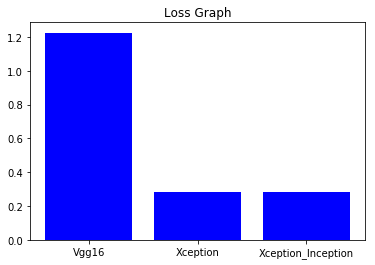

In [25]:
plt.bar(list(compare_loss.keys()), compare_loss.values(), color='b')
plt.xticks(range(0,3),list(compare_loss.keys()))
plt.title('Loss Graph')
plt.show()

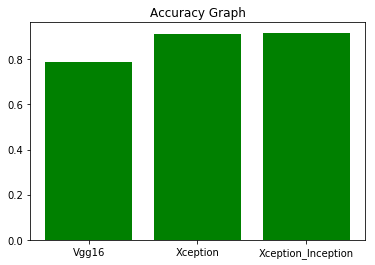

In [26]:
plt.bar(list(compare_accuracy.keys()), compare_accuracy.values(), color='g')
plt.xticks(range(0,3),list(compare_accuracy.keys()))
plt.title('Accuracy Graph')
plt.show()